In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


In [3]:
# Load the dataset
file_path = 'WHO-COVID-19-global-data.csv'  # Replace with the actual path to your file
df_data = pd.read_csv(file_path)

In [4]:
#  Drop the 'Country_code' and 'WHO_region' columns
df_cleaned = df_data.drop(columns=['Country_code', 'WHO_region'])

#Fill missing values in 'New_cases' and 'New_deaths' with 0
df_cleaned['New_cases'].fillna(0, inplace=True)
df_cleaned['New_deaths'].fillna(0, inplace=True)

# Convert 'Date_reported' to datetime format
df_cleaned['Date_reported'] = pd.to_datetime(df_cleaned['Date_reported'])


In [5]:
# Apply One-Hot Encoding to the 'Country' column
df_encoded = pd.get_dummies(df_cleaned, columns=['Country'], drop_first=True)

In [6]:
# Creating lag features for 'New_cases' to predict 'New_deaths'
# Lag of 1, 2, and 3 days.
df_encoded['New_cases_lag1'] = df_encoded['New_cases'].shift(1)
df_encoded['New_cases_lag2'] = df_encoded['New_cases'].shift(2)
df_encoded['New_cases_lag3'] = df_encoded['New_cases'].shift(3)

# Dropping any rows with NaN values that resulted from the lagging process
df_encoded.dropna(inplace=True)

In [7]:
# Define the target variable (New_deaths) and features
X = df_encoded.drop(columns=['Date_reported', 'New_deaths'])  # Exclude target and date columns
y = df_encoded['New_deaths']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Predict the target variable on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)


In [9]:
# Filter the dataset for the USA
df_usa = df_encoded[df_encoded['Country_United States of America'] == 1]

# Define the target variable (New_deaths) and features for the USA
X_usa = df_usa.drop(columns=['Date_reported', 'New_deaths'])  # Exclude target and date columns
y_usa = df_usa['New_deaths']

# Split the USA data into training and testing sets (e.g., 80% train, 20% test)
X_train_usa, X_test_usa, y_train_usa, y_test_usa = train_test_split(X_usa, y_usa, test_size=0.2, random_state=42)

# Train the model using the USA training data
model_usa = LinearRegression()
model_usa.fit(X_train_usa, y_train_usa)

# Predict the target variable on the USA testing set
y_pred_usa = model_usa.predict(X_test_usa)

# Evaluate the model's performance for the USA data
mse_usa = mean_squared_error(y_test_usa, y_pred_usa)
r2_usa = r2_score(y_test_usa, y_pred_usa)

mse_usa, r2_usa


(13074589.801575249, 0.5555808487105031)

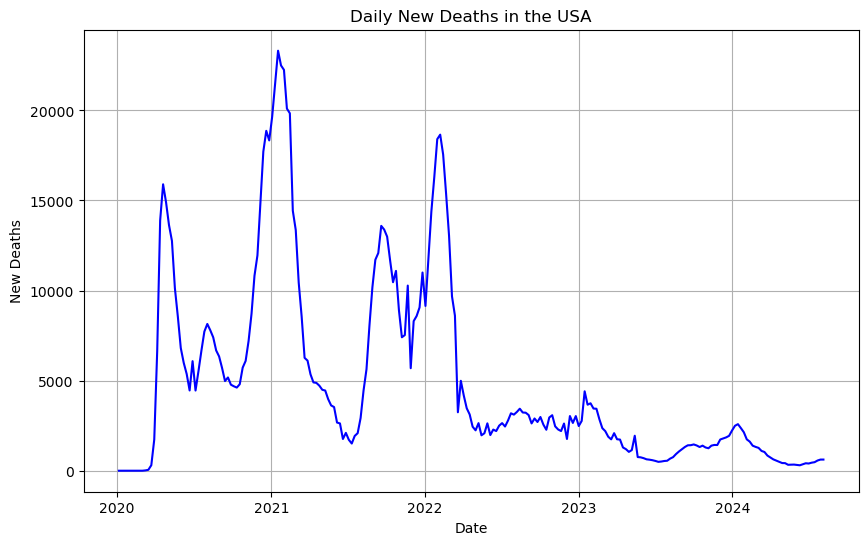

In [10]:
# Prepare the time series data for 'New_deaths' in the USA
usa_deaths_ts = df_usa.set_index('Date_reported')['New_deaths']

# Plot the time series to visualize it
plt.figure(figsize=(10, 6))
plt.plot(usa_deaths_ts, color='blue')
plt.title('Daily New Deaths in the USA')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.grid(True)
plt.show()

# Perform the Augmented Dickey-Fuller test to check for stationarity
adf_test = adfuller(usa_deaths_ts.dropna(), autolag='AIC')

# Extract and print the results
adf_stat = adf_test[0]
p_value = adf_test[1]
critical_values = adf_test[4]

c:\Users\Kris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Kris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\Kris\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


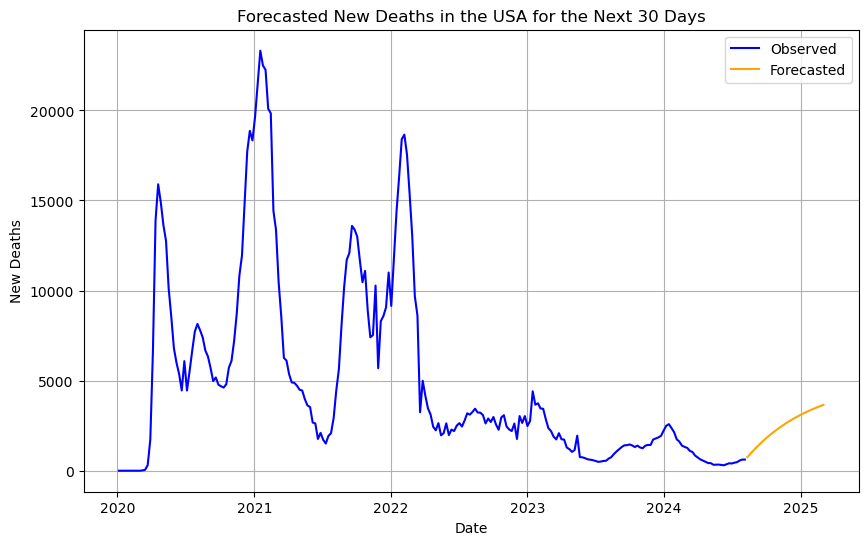

In [11]:
# Fit the ARIMA model
arima_model = ARIMA(usa_deaths_ts, order=(1, 0, 1))
arima_result = arima_model.fit()

# Forecast the next 30 days of new deaths
forecast_steps = 30
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=usa_deaths_ts.index[-1], periods=forecast_steps + 1, freq='W-SUN')[1:]

# Get the forecasted values
forecast_mean = forecast.predicted_mean

# Plot the forecasted values along with the actual values without confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(usa_deaths_ts, label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecasted', color='orange')
plt.title('Forecasted New Deaths in the USA for the Next 30 Days')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.legend()
plt.grid(True)
plt.show()

